In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df = pd.read_csv('Titanic.csv')
initial_shape = df.shape[0] * df.shape[1]

Удалим все строки данных содержащие пропуски.

In [31]:
df.dropna(inplace=True)

Удалим столбцы содержащие не числовые значения, за исключением столбцов Sex и Embarked

In [32]:
non_numeric_columns = ['Name', 'Ticket', 'Cabin']
df.drop(columns=non_numeric_columns, inplace=True)

Перекодируем данные в числовой вид в столбцах Sex и Embarked. Sex – 0 и 1, Embarked – 1,2,3

In [33]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

df['Embarked'] = df['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})

Удалим столбец PassengerId как не несущий полезной информации.

In [34]:
df.drop(columns=['PassengerId'], inplace=True)

Вычислим процент потерянных данных

In [35]:
lost_percent = ((initial_shape - df.shape[0] * df.shape[1]) / initial_shape) * 100
print(f"Процент потерянных данных: {lost_percent:.2f}%")

Процент потерянных данных: 86.31%


Разобьем полученные данные на обучающую и тестовые выборки

In [36]:
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Решим задачу классификации методом логистической регрессии

In [52]:
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

Дополним ноутбук метриками

In [57]:
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score, 
                             confusion_matrix, 
                             precision_recall_curve,
                             roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

Выведем метрики Precision, Recall и F1

In [48]:
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

Precision: 0.7407
Recall: 0.8696
F1-score: 0.8000


Отрисуем тепловую карту матрицы ошибок

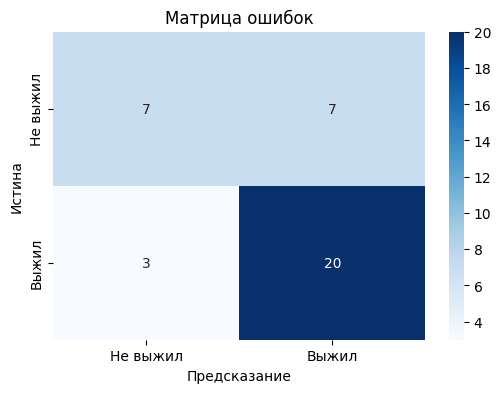

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не выжил', 'Выжил'], 
            yticklabels=['Не выжил', 'Выжил'])
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.title('Матрица ошибок')
plt.show()

Кривая Precision-Recall

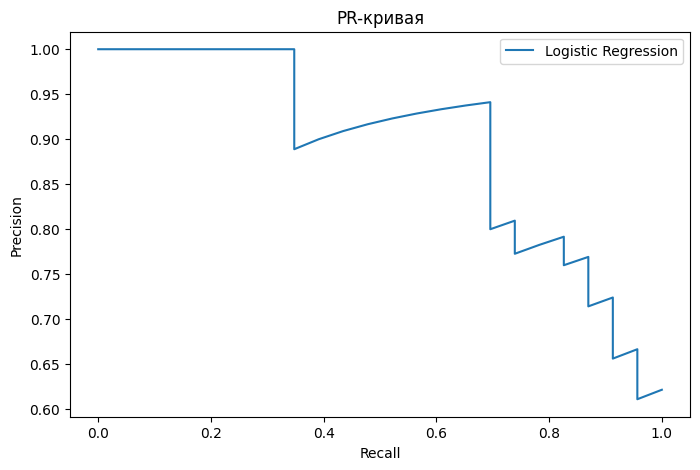

In [54]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,5))
plt.plot(recall, precision, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')
plt.legend()
plt.show()

ROC кривая

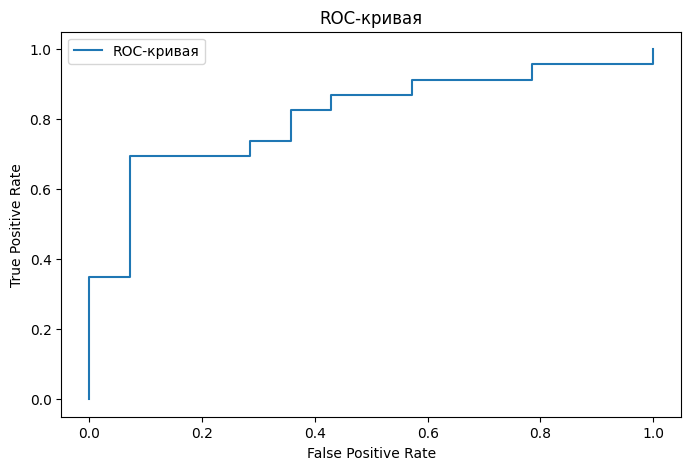

In [56]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Вывод: качество модели получилось средним. В целом все метрики в норме, но имеют не очень большие значения. PR-кривая и ROC-кривые нормальные. В целом модель склонна предсказывать 1.

Обучим модели логистической регресии, опорных векторов и ближайжих соседей.

In [69]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }


Сравним качества моделей

In [70]:
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}") 
    print(f"F1-score: {metrics['f1']:.4f}")


Logistic Regression:
Accuracy: 0.7297
Precision: 0.7407
Recall: 0.8696
F1-score: 0.8000

SVM:
Accuracy: 0.6216
Precision: 0.6216
Recall: 1.0000
F1-score: 0.7667

KNN:
Accuracy: 0.6757
Precision: 0.6774
Recall: 0.9130
F1-score: 0.7778


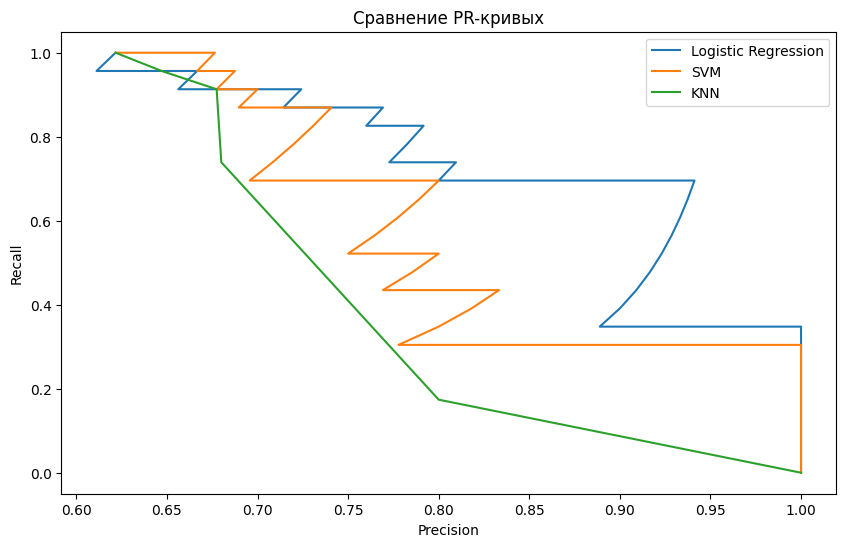

In [77]:
plt.figure(figsize=(10,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(precision, recall, label=f'{name}')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Сравнение PR-кривых')
plt.legend()
plt.show()

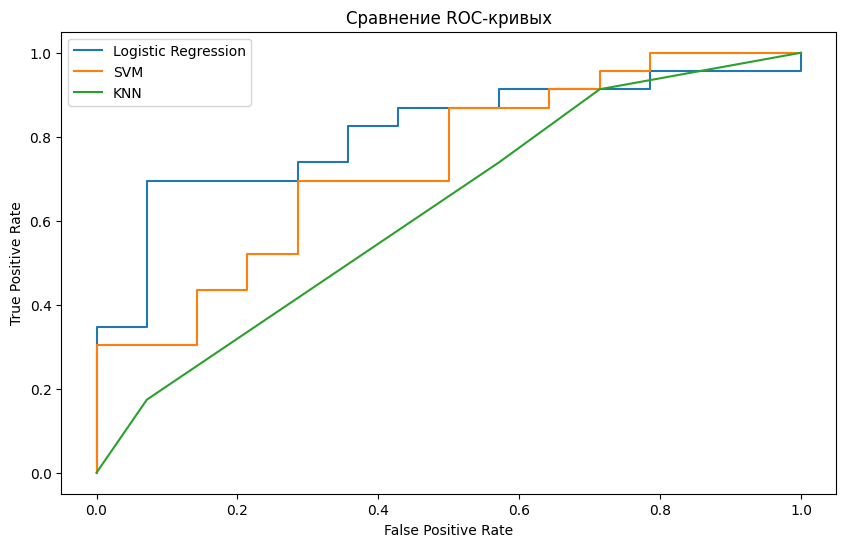

In [72]:
plt.figure(figsize=(10,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых')
plt.legend()
plt.show()

Выведем тепловые карты матриц ошибок SVM и KNN

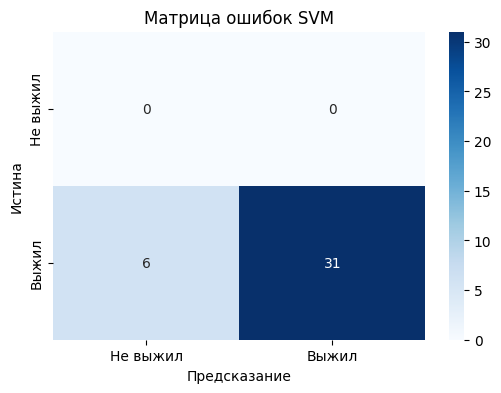

In [75]:
cm = confusion_matrix(models["SVM"].predict(X_test), y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не выжил', 'Выжил'], 
            yticklabels=['Не выжил', 'Выжил'])
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.title('Матрица ошибок SVM')
plt.show()

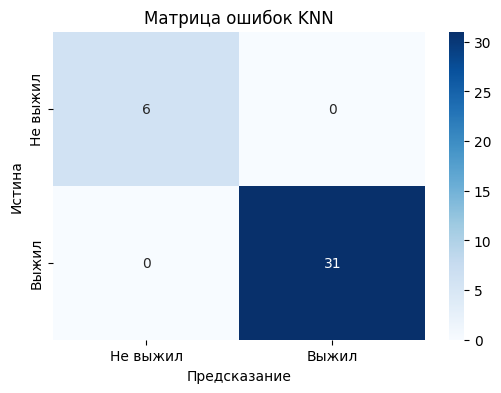

In [76]:
cm = confusion_matrix(models["KNN"].predict(X_test), y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не выжил', 'Выжил'], 
            yticklabels=['Не выжил', 'Выжил'])
plt.xlabel('Предсказание')
plt.ylabel('Истина')
plt.title('Матрица ошибок KNN')
plt.show()

Лучшей моделью оказалась логистическая регрессия. Она лучше всех отделяет 0 от 1. SVM совсем не умеет предсказывать 0. KNN предсказывает лучше, но все равно часто ошибается, принимая 0 как 1.